# **Gesture Recognition**

## **Problem Statement**

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

1. Thumbs up:  Increase the volume
2. Thumbs down: Decrease the volume
3. Left swipe: 'Jump' backwards 10 seconds
4. Right swipe: 'Jump' forward 10 seconds  
5. Stop: Pause the movie

## **About the Dataset**

The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use. 

## **1. Importing libraries and loading dataset**

In [1]:
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 101kB/s 
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [2]:
# Importing libraries
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.misc import imread, imresize
import datetime
import warnings
import os

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop

plt.style.use('seaborn')
warnings.simplefilter(action='ignore')


We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip '/content/drive/MyDrive/Colab Notebooks/Upgrad_Gesture_Recognition(CNN+RNN)/dataset/Project_data.zip'

Streaming output truncated to the last 5000 lines.
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00001.png  
 extracting: Project_data/t

In [6]:
!nvidia-smi

Mon May 10 12:00:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
train_doc = np.random.permutation(open('/content/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/Project_data/val.csv').readlines())

train_doc & val_doc contain folder name, class_label & class_index

In [8]:
print(len(train_doc))
print(type(train_doc))
print(train_doc[:5])

663
<class 'numpy.ndarray'>
['WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1\n'
 'WIN_20180925_18_02_58_Pro_Thumbs_Down_new;Thumbs_Down_new;3\n'
 'WIN_20180925_17_33_08_Pro_Left_Swipe_new;Left_Swipe_new;0\n'
 'WIN_20180925_17_51_17_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n'
 'WIN_20180926_17_17_35_Pro_Left_Swipe_new;Left_Swipe_new;0\n']


## **2. Defining custom Generator**
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [9]:
def normalize_image(img):
    '''
    Perfroms min-max normalization on provided image and returns it.
    '''
    normalized_image= (img - np.min(img))/(np.max(img)- np.min(img))
    return normalized_image

In [10]:
def batch_datagen(batch, source_path, t, excess=0):
  img_idx = [0,1,4,6,8,10,12,14,16,18,20,22,25,28,29]
  frames_count = len(img_idx)
  batch_data = np.zeros((batch_size,frames_count,img_height,img_width,channels))
  batch_labels = np.zeros((batch_size,5))
  folders = batch_size if excess == 0 else excess
  for folder in range(folders):
    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
    for idx,item in enumerate(img_idx):
      image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
      resized_image = imresize(image,(img_height,img_width))
      batch_data[folder,idx,:,:,0] = normalize_image(resized_image[:, : , 0])
      batch_data[folder,idx,:,:,1] = normalize_image(resized_image[:, : , 1])
      batch_data[folder,idx,:,:,2] = normalize_image(resized_image[:, : , 2])
    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
  return batch_data, batch_labels

In [11]:
def generator(source_path, folder_list, batch_size, exclude_last_batch):
    while True:
      t = np.random.permutation(folder_list) # To reduce bias
      num_batches = len(folder_list) // batch_size # calculate the number of batches
      for batch in range(num_batches): # iterates over the batches
        batch_data, batch_labels = batch_datagen(batch, source_path, t)
        yield batch_data, batch_labels
      
      excess = len(t)%batch_size
      if excess != 0 and exclude_last_batch == False:
        batch_data, batch_labels = batch_datagen(batch, source_path, t, excess)
        yield batch_data, batch_labels

## **3. Experimentation**
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Defining function custom functions

Function for generator initialization and model training.

In [12]:
def train_model(model, exclude_last_batch=False):
  print("Initializing generators ...")
  train_path = '/content/Project_data/train'
  val_path = '/content/Project_data/val'
  train_generator = generator(train_path, train_doc, batch_size, exclude_last_batch)
  val_generator = generator(val_path, val_doc, batch_size, exclude_last_batch)

  print("Initializing callbacks ...")
  curr_dt_time = datetime.datetime.now()
  model_name = '3D_CNN_model' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
  if not os.path.exists(model_name):
      os.mkdir(model_name)
  filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

  # Callback for saving model check points
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

  # Callback for reducing optimizing learning rate
  LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
  callbacks_list = [checkpoint, LR]
  
  # Calculating number of steps per epoch
  num_train_sequences = len(train_doc)  
  num_val_sequences = len(val_doc)
  if (num_train_sequences%batch_size) == 0 or exclude_last_batch == True:
      steps_per_epoch = int(num_train_sequences/batch_size)
  else:
      steps_per_epoch = (num_train_sequences//batch_size) + 1

  if (num_val_sequences%batch_size) == 0 or exclude_last_batch == True:
      validation_steps = int(num_val_sequences/batch_size)
  else:
      validation_steps = (num_val_sequences//batch_size) + 1
  print('Number of training sequences =', num_train_sequences)
  print('Number of validation sequences =', num_val_sequences)
  print('Train steps per epoch =',steps_per_epoch)
  print('Validation steps per epoch =',validation_steps) 

  # Training the model
  print('Training the model ...')
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
  
  return model.history.history

Function for visualizing training and validation curves.

In [13]:
def plot_validation_curves(result):
  result = pd.DataFrame(result)
  fig, axs = plt.subplots(1,2)
  result[['loss','val_loss']].plot(figsize=(10, 3),ax=axs[0])
  axs[0].set_title('Train vs validation Loss')
  axs[0].set_xlabel('Epochs')
  axs[0].set_ylabel('Loss')
  result[['categorical_accuracy','val_categorical_accuracy']].plot(figsize=(10, 3),ax=axs[1])
  axs[1].set_title('Train vs validation Accuracy')
  axs[1].set_xlabel('Epochs')
  axs[1].set_ylabel('Accuracy')

## **Experiment 0 : Using entire video to train the model** 



**Setting batch size = 64, frames_per_video = 30 and image_size=(160x160x3) caused generator error.**

## **Experiment 1 : Training the base model** 

Parameter settings

- No. of frames used per video : 15
- Optimizer : Adam(learning_rate=3e-4)
- Frame dimension : 100x100x3
- activation : 'relu'
- filter size : 3x3x3
- BatchNormalization : No
- Dropout : No
- Batch size : 32

In [14]:
# Initializing paramaters

batch_size = 32
num_epochs = 20

img_height = 100
img_width = 100
channels = 3
frames_per_vid = 15
input_shape = (frames_per_vid,img_height,img_width,channels)

nb_classes = 5
filter_size = (3,3,3)

In [15]:
model_1 = Sequential()
model_1.add(Conv3D(32, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
model_1.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_1.add(Conv3D(64, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same'))
model_1.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_1.add(Conv3D(128, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same'))
model_1.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_1.add(Conv3D(256, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same'))
model_1.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_1.add(Conv3D(256, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same'))
model_1.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_1.add(Flatten())
model_1.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_1.add(Dense(units=nb_classes, activation='softmax'))

opt = Adam(learning_rate=3e-4)
model_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 100, 100, 32)  2624      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 50, 50, 32)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 50, 50, 64)     55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 4, 25, 25, 64)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 4, 25, 25, 128)    221312    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 2, 13, 13, 128)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 2, 13, 13, 256)    8

In [16]:
history = train_model(model_1)

Initializing generators ...
Initializing callbacks ...
Number of training sequences = 663
Number of validation sequences = 100
Train steps per epoch = 21
Validation steps per epoch = 4
Training the model ...
Epoch 1/20
21/21 [==============================] - 86s 3s/step - loss: 1.9008 - categorical_accuracy: 0.1912 - val_loss: 1.2170 - val_categorical_accuracy: 0.2578

Epoch 00001: saving model to 3D_CNN_model_2021-05-1012_01_06.752165/model-00001-1.69446-0.23065-1.21699-0.25781.h5
Epoch 2/20
21/21 [==============================] - 55s 3s/step - loss: 1.5366 - categorical_accuracy: 0.2987 - val_loss: 1.1820 - val_categorical_accuracy: 0.2422

Epoch 00002: saving model to 3D_CNN_model_2021-05-1012_01_06.752165/model-00002-1.51439-0.30060-1.18200-0.24219.h5
Epoch 3/20
21/21 [==============================] - 54s 3s/step - loss: 1.4819 - categorical_accuracy: 0.3276 - val_loss: 1.0051 - val_categorical_accuracy: 0.3203

Epoch 00003: saving model to 3D_CNN_model_2021-05-1012_01_06.752165

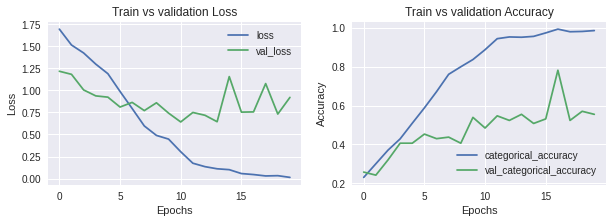

In [17]:
plot_validation_curves(history)

**Reducing batch size to 32, frames_per_video to 15 and image_size to (100,100,3) resolved generator error.**

## **Experiment 2 : Training base model with BatchNormalization layer included** 

Parameter settings

- No. of frames used per video : 15
- Optimizer : Adam(learning_rate=3e-4)
- Frame dimension : 100x100x3
- activation : 'relu'
- filter size : 3x3x3
- BatchNormalization : Yes
- Dropout : No
- Batch size : 32

In [18]:
# Initializing paramaters

batch_size = 32
num_epochs = 20

img_height = 100
img_width = 100
channels = 3
frames_per_vid = 15
input_shape = (frames_per_vid,img_height,img_width,channels)

nb_classes = 5
filter_size = (3,3,3)

In [19]:
model_2 = Sequential()
model_2.add(Conv3D(32, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
model_2.add(BatchNormalization())
model_2.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_2.add(Conv3D(64, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_2.add(Conv3D(128, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_2.add(Conv3D(256, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_2.add(Conv3D(256, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_2.add(Flatten())
model_2.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_2.add(Dense(units=nb_classes, activation='softmax'))

opt = Adam(learning_rate=3e-4)
model_2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 15, 100, 100, 32)  2624      
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 100, 100, 32)  128       
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 8, 50, 50, 32)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 8, 50, 50, 64)     55360     
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 50, 50, 64)     256       
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 4, 25, 25, 64)     0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 4, 25, 25, 128)   

In [20]:
history = train_model(model_2)

Initializing generators ...
Initializing callbacks ...
Number of training sequences = 663
Number of validation sequences = 100
Train steps per epoch = 21
Validation steps per epoch = 4
Training the model ...
Epoch 1/20
21/21 [==============================] - 57s 3s/step - loss: 2.0329 - categorical_accuracy: 0.3458 - val_loss: 1.6137 - val_categorical_accuracy: 0.1797

Epoch 00001: saving model to 3D_CNN_model_2021-05-1012_19_22.903821/model-00001-1.59375-0.41220-1.61374-0.17969.h5
Epoch 2/20
21/21 [==============================] - 54s 3s/step - loss: 0.6430 - categorical_accuracy: 0.7997 - val_loss: 1.1713 - val_categorical_accuracy: 0.2188

Epoch 00002: saving model to 3D_CNN_model_2021-05-1012_19_22.903821/model-00002-0.58322-0.79911-1.17134-0.21875.h5
Epoch 3/20
21/21 [==============================] - 54s 3s/step - loss: 0.3209 - categorical_accuracy: 0.8825 - val_loss: 1.3687 - val_categorical_accuracy: 0.1797

Epoch 00003: saving model to 3D_CNN_model_2021-05-1012_19_22.903821

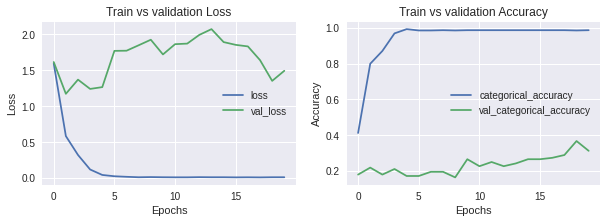

In [21]:
plot_validation_curves(history)

**Added BN layer to reduce the number of training epochs. However, it amplified overfitting.**

## **Experiment 3 : Training base model with BatchNormalization layer & last batch excluded** 

Parameter settings

- No. of frames used per video : 15
- Optimizer : Adam(learning_rate=3e-4)
- Frame dimension : 100x100x3
- activation : 'relu'
- filter size : 3x3x3
- BatchNormalization : Yes
- Dropout : No
- Batch size : 32

In [22]:
# Initializing paramaters

batch_size = 32
num_epochs = 20

img_height = 100
img_width = 100
channels = 3
frames_per_vid = 15
input_shape = (frames_per_vid,img_height,img_width,channels)

nb_classes = 5
filter_size = (3,3,3)

In [23]:
model_3 = Sequential()
model_3.add(Conv3D(32, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
model_3.add(BatchNormalization())
model_3.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_3.add(Conv3D(64, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_3.add(Conv3D(128, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_3.add(Conv3D(256, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_3.add(Conv3D(256, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_3.add(Flatten())
model_3.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_3.add(Dense(units=nb_classes, activation='softmax'))

opt = Adam(learning_rate=3e-4)
model_3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_10 (Conv3D)           (None, 15, 100, 100, 32)  2624      
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 100, 100, 32)  128       
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 8, 50, 50, 32)     0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 8, 50, 50, 64)     55360     
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 50, 50, 64)     256       
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 4, 25, 25, 64)     0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 4, 25, 25, 128)   

In [24]:
history = train_model(model_3, exclude_last_batch=True)

Initializing generators ...
Initializing callbacks ...
Number of training sequences = 663
Number of validation sequences = 100
Train steps per epoch = 20
Validation steps per epoch = 3
Training the model ...
Epoch 1/20
20/20 [==============================] - 53s 3s/step - loss: 1.7144 - categorical_accuracy: 0.3694 - val_loss: 2.5146 - val_categorical_accuracy: 0.2812

Epoch 00001: saving model to 3D_CNN_model_2021-05-1012_37_17.250441/model-00001-1.41276-0.43906-2.51464-0.28125.h5
Epoch 2/20
20/20 [==============================] - 51s 3s/step - loss: 0.7367 - categorical_accuracy: 0.6971 - val_loss: 1.4781 - val_categorical_accuracy: 0.3021

Epoch 00002: saving model to 3D_CNN_model_2021-05-1012_37_17.250441/model-00002-0.64485-0.74687-1.47811-0.30208.h5
Epoch 3/20
20/20 [==============================] - 51s 3s/step - loss: 0.2518 - categorical_accuracy: 0.9172 - val_loss: 1.4784 - val_categorical_accuracy: 0.4062

Epoch 00003: saving model to 3D_CNN_model_2021-05-1012_37_17.250441

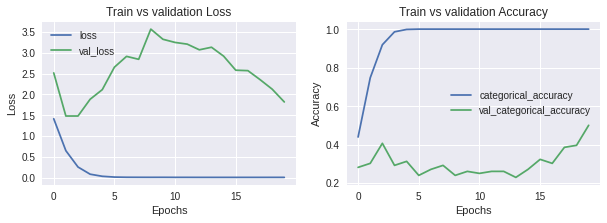

In [26]:
plot_validation_curves(history)

In [27]:
!nvidia-smi

Mon May 10 12:54:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    70W / 149W |   8581MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Removed last training/validation batch from the training phase, as it led to improper calculation of running mean and variance in BN layer.[[src]]( https://stackoverflow.com/questions/37859546/overfitting-with-batch-normalization-tensorflow)**

## **Experiment 4 : Training `model_3` with dropout layer included** 


Parameter settings

- No. of frames used per video : 15
- Optimizer : Adam(learning_rate=3e-4)
- Frame dimension : 100x100x3
- activation : 'relu'
- filter size : 3x3x3
- BatchNormalization : Yes
- Dropout : Yes
- Batch size : 32

In [28]:
# Initializing paramaters

batch_size = 32
num_epochs = 20

img_height = 100
img_width = 100
channels = 3
frames_per_vid = 15
input_shape = (frames_per_vid,img_height,img_width,channels)

nb_classes = 5
filter_size = (3,3,3)

In [29]:
model_4 = Sequential()
model_4.add(Conv3D(32, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.25))
model_4.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_4.add(Conv3D(64, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.25))
model_4.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_4.add(Conv3D(128, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.25))
model_4.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_4.add(Conv3D(256, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.25))
model_4.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_4.add(Conv3D(256, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.25))
model_4.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_4.add(Flatten())
model_4.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_4.add(Dropout(0.25))
model_4.add(Dense(units=nb_classes, activation='softmax'))

opt = Adam(learning_rate=3e-4)
model_4.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_15 (Conv3D)           (None, 15, 100, 100, 32)  2624      
_________________________________________________________________
batch_normalization_10 (Batc (None, 15, 100, 100, 32)  128       
_________________________________________________________________
dropout (Dropout)            (None, 15, 100, 100, 32)  0         
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 8, 50, 50, 32)     0         
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 8, 50, 50, 64)     55360     
_________________________________________________________________
batch_normalization_11 (Batc (None, 8, 50, 50, 64)     256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 50, 50, 64)    

In [30]:
history = train_model(model_4, exclude_last_batch=True)

Initializing generators ...
Initializing callbacks ...
Number of training sequences = 663
Number of validation sequences = 100
Train steps per epoch = 20
Validation steps per epoch = 3
Training the model ...
Epoch 1/20
20/20 [==============================] - 55s 3s/step - loss: 2.2618 - categorical_accuracy: 0.2987 - val_loss: 1.5183 - val_categorical_accuracy: 0.3333

Epoch 00001: saving model to 3D_CNN_model_2021-05-1012_54_23.634332/model-00001-1.87813-0.35938-1.51831-0.33333.h5
Epoch 2/20
20/20 [==============================] - 51s 3s/step - loss: 1.1547 - categorical_accuracy: 0.5264 - val_loss: 3.3444 - val_categorical_accuracy: 0.1146

Epoch 00002: saving model to 3D_CNN_model_2021-05-1012_54_23.634332/model-00002-1.09307-0.55000-3.34436-0.11458.h5
Epoch 3/20
20/20 [==============================] - 52s 3s/step - loss: 0.8489 - categorical_accuracy: 0.6625 - val_loss: 5.1719 - val_categorical_accuracy: 0.1562

Epoch 00003: saving model to 3D_CNN_model_2021-05-1012_54_23.634332

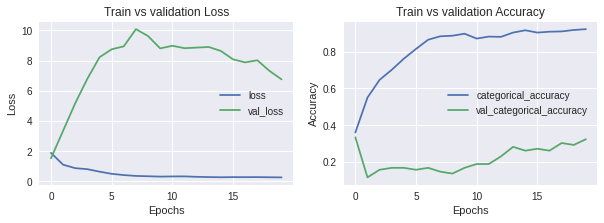

In [31]:
plot_validation_curves(history)

**Included dropout layer in between layers to reduce overfitting. However, the model doesn't seem to generalize well.**

## **Experiment 5 : Training base model with filter size of `2x2x2`** 

Parameter settings

- No. of frames used per video : 15
- Optimizer : Adam(learning_rate=3e-4)
- Frame dimension : 100x100x3
- activation : 'relu'
- filter size : 2x2x2
- BatchNormalization : No
- Dropout : No
- Batch size : 32

In [32]:
# Initializing paramaters

batch_size = 32
num_epochs = 20

img_height = 100
img_width = 100
channels = 3
frames_per_vid = 15
input_shape = (frames_per_vid,img_height,img_width,channels)

nb_classes = 5
filter_size = (2,2,2)

In [33]:
model_5 = Sequential()
model_5.add(Conv3D(32, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
model_5.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_5.add(Conv3D(64, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same'))
model_5.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_5.add(Conv3D(128, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same'))
model_5.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_5.add(Conv3D(256, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same'))
model_5.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_5.add(Conv3D(256, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same'))
model_5.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_5.add(Flatten())
model_5.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_5.add(Dense(units=nb_classes, activation='softmax'))

opt = Adam(learning_rate=3e-4)
model_5.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_20 (Conv3D)           (None, 15, 100, 100, 32)  800       
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 8, 50, 50, 32)     0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 8, 50, 50, 64)     16448     
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 4, 25, 25, 64)     0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 4, 25, 25, 128)    65664     
_________________________________________________________________
max_pooling3d_22 (MaxPooling (None, 2, 13, 13, 128)    0         
_________________________________________________________________
conv3d_23 (Conv3D)           (None, 2, 13, 13, 256)   

In [34]:
history = train_model(model_5)

Initializing generators ...
Initializing callbacks ...
Number of training sequences = 663
Number of validation sequences = 100
Train steps per epoch = 21
Validation steps per epoch = 4
Training the model ...
Epoch 1/20
21/21 [==============================] - 51s 2s/step - loss: 1.7506 - categorical_accuracy: 0.2520 - val_loss: 1.2232 - val_categorical_accuracy: 0.1797

Epoch 00001: saving model to 3D_CNN_model_2021-05-1013_11_49.721599/model-00001-1.64606-0.26339-1.22321-0.17969.h5
Epoch 2/20
21/21 [==============================] - 50s 2s/step - loss: 1.5372 - categorical_accuracy: 0.3031 - val_loss: 1.1281 - val_categorical_accuracy: 0.2812

Epoch 00002: saving model to 3D_CNN_model_2021-05-1013_11_49.721599/model-00002-1.50261-0.30804-1.12814-0.28125.h5
Epoch 3/20
21/21 [==============================] - 50s 2s/step - loss: 1.4557 - categorical_accuracy: 0.3626 - val_loss: 1.0967 - val_categorical_accuracy: 0.2891

Epoch 00003: saving model to 3D_CNN_model_2021-05-1013_11_49.721599

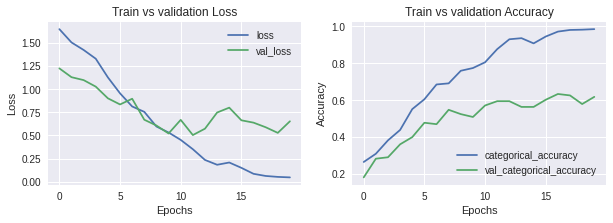

In [35]:
plot_validation_curves(history)

**Reduction in filter size significantly reduced the total number of trainable parameters.**

## **Experiment 6 : Training `model_5` with dropout layer included** 

Parameter settings

- No. of frames used per video : 15
- Optimizer : Adam(learning_rate=3e-4)
- Frame dimension : 100x100x3
- activation : 'relu'
- filter size : 2x2x2
- BatchNormalization : No
- Dropout : Yes
- Batch size : 32

In [36]:
# Initializing paramaters

batch_size = 32
num_epochs = 20

img_height = 100
img_width = 100
channels = 3
frames_per_vid = 15
input_shape = (frames_per_vid,img_height,img_width,channels)

nb_classes = 5
filter_size = (2,2,2)

In [37]:
model_6 = Sequential()
model_6.add(Conv3D(32, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
model_6.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_6.add(Conv3D(64, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same'))
model_6.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_6.add(Conv3D(128, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same'))
model_6.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_6.add(Conv3D(256, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same'))
model_6.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_6.add(Conv3D(256, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same'))
model_6.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_6.add(Flatten())
model_6.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_6.add(Dropout(0.25))
model_6.add(Dense(units=nb_classes, activation='softmax'))

opt = Adam(learning_rate=3e-4)
model_6.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_25 (Conv3D)           (None, 15, 100, 100, 32)  800       
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 8, 50, 50, 32)     0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 8, 50, 50, 64)     16448     
_________________________________________________________________
max_pooling3d_26 (MaxPooling (None, 4, 25, 25, 64)     0         
_________________________________________________________________
conv3d_27 (Conv3D)           (None, 4, 25, 25, 128)    65664     
_________________________________________________________________
max_pooling3d_27 (MaxPooling (None, 2, 13, 13, 128)    0         
_________________________________________________________________
conv3d_28 (Conv3D)           (None, 2, 13, 13, 256)   

In [38]:
history = train_model(model_6)

Initializing generators ...
Initializing callbacks ...
Number of training sequences = 663
Number of validation sequences = 100
Train steps per epoch = 21
Validation steps per epoch = 4
Training the model ...
Epoch 1/20
21/21 [==============================] - 50s 2s/step - loss: 1.7208 - categorical_accuracy: 0.2286 - val_loss: 1.2060 - val_categorical_accuracy: 0.3047

Epoch 00001: saving model to 3D_CNN_model_2021-05-1013_28_16.346272/model-00001-1.62835-0.24405-1.20603-0.30469.h5
Epoch 2/20
21/21 [==============================] - 49s 2s/step - loss: 1.5440 - categorical_accuracy: 0.3246 - val_loss: 1.1133 - val_categorical_accuracy: 0.3047

Epoch 00002: saving model to 3D_CNN_model_2021-05-1013_28_16.346272/model-00002-1.50641-0.33333-1.11329-0.30469.h5
Epoch 3/20
21/21 [==============================] - 49s 2s/step - loss: 1.4602 - categorical_accuracy: 0.3480 - val_loss: 0.9827 - val_categorical_accuracy: 0.4453

Epoch 00003: saving model to 3D_CNN_model_2021-05-1013_28_16.346272

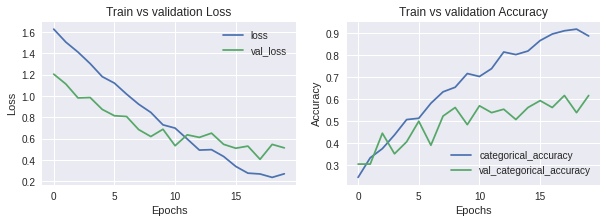

In [39]:
plot_validation_curves(history)

**Introducing a dropout layer in between fully connected layers slightly improved model generalizability.**

## **Experiment 7 : Training `model_5` for 30 epochs** 

Parameter settings

- No. of frames used per video : 15
- Optimizer : Adam(learning_rate=3e-4)
- Frame dimension : 100x100x3
- activation : 'relu'
- filter size : 2x2x2
- BatchNormalization : No
- Dropout : Yes
- Batch size : 32

In [40]:
# Initializing paramaters

batch_size = 32
num_epochs = 30

img_height = 100
img_width = 100
channels = 3
frames_per_vid = 15
input_shape = (frames_per_vid,img_height,img_width,channels)

nb_classes = 5
filter_size = (2,2,2)

In [41]:
model_7 = Sequential()
model_7.add(Conv3D(32, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
model_7.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_7.add(Conv3D(64, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same'))
model_7.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_7.add(Conv3D(128, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same'))
model_7.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_7.add(Conv3D(256, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same'))
model_7.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_7.add(Conv3D(256, kernel_size=filter_size, activation='relu', kernel_initializer='he_uniform', padding='same'))
model_7.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_7.add(Flatten())
model_7.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_7.add(Dropout(0.25))
model_7.add(Dense(units=nb_classes, activation='softmax'))

opt = Adam(learning_rate=3e-4)
model_7.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_7.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_30 (Conv3D)           (None, 15, 100, 100, 32)  800       
_________________________________________________________________
max_pooling3d_30 (MaxPooling (None, 8, 50, 50, 32)     0         
_________________________________________________________________
conv3d_31 (Conv3D)           (None, 8, 50, 50, 64)     16448     
_________________________________________________________________
max_pooling3d_31 (MaxPooling (None, 4, 25, 25, 64)     0         
_________________________________________________________________
conv3d_32 (Conv3D)           (None, 4, 25, 25, 128)    65664     
_________________________________________________________________
max_pooling3d_32 (MaxPooling (None, 2, 13, 13, 128)    0         
_________________________________________________________________
conv3d_33 (Conv3D)           (None, 2, 13, 13, 256)   

In [42]:
history = train_model(model_7)

Initializing generators ...
Initializing callbacks ...
Number of training sequences = 663
Number of validation sequences = 100
Train steps per epoch = 21
Validation steps per epoch = 4
Training the model ...
Epoch 1/30
21/21 [==============================] - 51s 2s/step - loss: 1.7257 - categorical_accuracy: 0.2004 - val_loss: 1.2211 - val_categorical_accuracy: 0.1562

Epoch 00001: saving model to 3D_CNN_model_2021-05-1013_44_37.055510/model-00001-1.63246-0.22321-1.22107-0.15625.h5
Epoch 2/30
21/21 [==============================] - 50s 2s/step - loss: 1.5410 - categorical_accuracy: 0.2892 - val_loss: 1.1162 - val_categorical_accuracy: 0.3438

Epoch 00002: saving model to 3D_CNN_model_2021-05-1013_44_37.055510/model-00002-1.51308-0.31548-1.11620-0.34375.h5
Epoch 3/30
21/21 [==============================] - 50s 2s/step - loss: 1.4370 - categorical_accuracy: 0.4069 - val_loss: 1.0243 - val_categorical_accuracy: 0.4375

Epoch 00003: saving model to 3D_CNN_model_2021-05-1013_44_37.055510

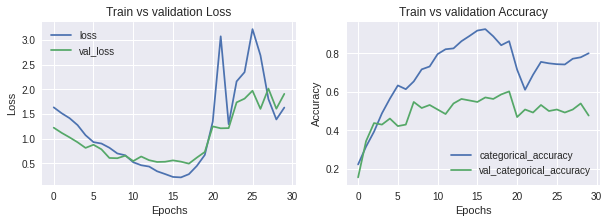

In [43]:
plot_validation_curves(history)

**Trained model_6 for 30 epochs, to check whether model performance will improve. However model became unstable after 20 epochs.**

## **Experiment 8 : Training 2D_CNN+LSTM Model** 

Parameter settings

- No. of frames used per video : 15
- Optimizer : Adam(learning_rate=3e-4)
- Frame dimension : 100x100x3
- activation : 'relu'
- filter size : 3x3
- BatchNormalization : Yes
- Dropout : Yes
- Batch size : 32

In [44]:
# Initializing paramaters

batch_size = 32
num_epochs = 30

img_height = 100
img_width = 100
channels = 3
frames_per_vid = 15
input_shape = (frames_per_vid,img_height,img_width,channels)

nb_classes = 5
filter_size = (3,3)

In [45]:
model_8 = Sequential()

model_8.add(TimeDistributed(Conv2D(16, filter_size , padding='same', activation='relu'), input_shape=input_shape))
model_8.add(TimeDistributed(BatchNormalization()))
model_8.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_8.add(TimeDistributed(Conv2D(32, filter_size , padding='same', activation='relu')))
model_8.add(TimeDistributed(BatchNormalization()))
model_8.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_8.add(TimeDistributed(Conv2D(64, filter_size , padding='same', activation='relu')))
model_8.add(TimeDistributed(BatchNormalization()))
model_8.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_8.add(TimeDistributed(Conv2D(128, filter_size , padding='same', activation='relu')))
model_8.add(TimeDistributed(BatchNormalization()))
model_8.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_8.add(TimeDistributed(Conv2D(256, filter_size , padding='same', activation='relu')))
model_8.add(TimeDistributed(BatchNormalization()))
model_8.add(TimeDistributed(MaxPooling2D((2, 2))))

model_8.add(TimeDistributed(Flatten()))
model_8.add(LSTM(128))
model_8.add(Dropout(0.25))
model_8.add(Dense(64,activation='relu'))
model_8.add(Dropout(0.25))
model_8.add(Dense(units=nb_classes, activation='softmax'))

opt = Adam(learning_rate=3e-4)
model_8.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_8.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 25, 25, 64)   

In [46]:
history = train_model(model_8)

Initializing generators ...
Initializing callbacks ...
Number of training sequences = 663
Number of validation sequences = 100
Train steps per epoch = 21
Validation steps per epoch = 4
Training the model ...
Epoch 1/30
21/21 [==============================] - 53s 2s/step - loss: 1.5761 - categorical_accuracy: 0.2931 - val_loss: 1.2356 - val_categorical_accuracy: 0.2422

Epoch 00001: saving model to 3D_CNN_model_2021-05-1014_09_07.355167/model-00001-1.47985-0.33482-1.23562-0.24219.h5
Epoch 2/30
21/21 [==============================] - 48s 2s/step - loss: 1.1890 - categorical_accuracy: 0.5402 - val_loss: 1.2755 - val_categorical_accuracy: 0.1406

Epoch 00002: saving model to 3D_CNN_model_2021-05-1014_09_07.355167/model-00002-1.12942-0.53274-1.27550-0.14062.h5
Epoch 3/30
21/21 [==============================] - 48s 2s/step - loss: 0.9935 - categorical_accuracy: 0.6141 - val_loss: 1.3051 - val_categorical_accuracy: 0.1484

Epoch 00003: saving model to 3D_CNN_model_2021-05-1014_09_07.355167

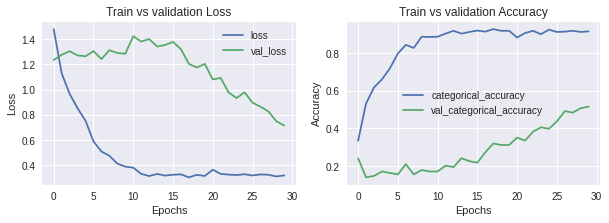

In [47]:
plot_validation_curves(history)

**Initially, validation metrics remained plateaued. However, after the 15th epoch a gradual improvement can be seen in validation_accuracy and loss.**

# **4. Summary**

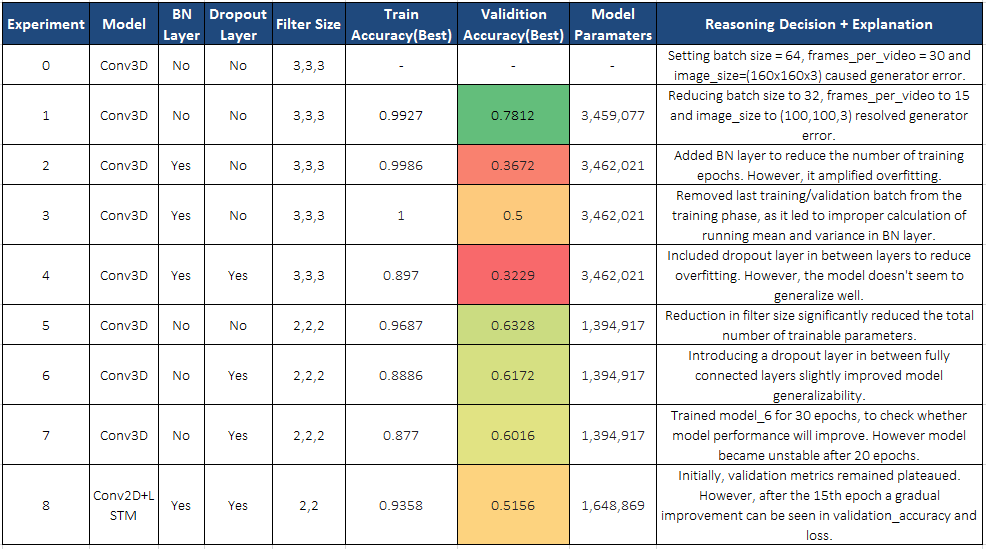